**Легенда**

Вы работаете в стартапе, который продаёт продукты питания. Нужно разобраться, как ведут себя пользователи вашего мобильного приложения.

Цели проекта: 
* изучить воронку продаж,
* выяснить, какой шрифт лучше по результатам A/B-теста.

## Шаг 1. Откройте файл с данными и изучите общую информацию

In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import math as mth
import seaborn as sns

In [2]:
df = pd.read_csv('/datasets/logs_exp.csv', sep='\t')
df.sample(5)

,EventName,DeviceIDHash,EventTimestamp,ExpId
218836,MainScreenAppear,3524803751765120333,1565163346,248
176940,MainScreenAppear,6567204119970586330,1565046168,246
130371,CartScreenAppear,6932517045703054087,1564932872,248
105343,PaymentScreenSuccessful,5892436657040909299,1564859612,247
53279,MainScreenAppear,4527484608661947777,1564743914,246


## Шаг 2. Подготовьте данные

**Замените названия столбцов на удобные для вас**

In [3]:
df.columns = ['event', 'user_id', 'datetime', 'group']
df.sample(3)

,event,user_id,datetime,group
113731,PaymentScreenSuccessful,2045616237532505490,1564905629,248
229963,MainScreenAppear,5274212389021166684,1565185498,248
186227,MainScreenAppear,4891111378981166101,1565081040,248


**Проверьте пропуски и типы данных. Откорректируйте, если нужно**

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
event       244126 non-null object
user_id     244126 non-null int64
datetime    244126 non-null int64
group       244126 non-null int64
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [5]:
df.duplicated().sum()

413

In [6]:
df = df.drop_duplicates().reset_index(drop = True)

**Добавьте столбец даты и времени, а также отдельный столбец дат**

In [7]:
df['datetime']= pd.to_datetime(df['datetime'], unit = 's' )
df['date'] = df['datetime'].dt.date
df.sample(3)  

,event,user_id,datetime,group,date
35288,MainScreenAppear,1035766790164458922,2019-08-01 19:10:22,246,2019-08-01
154772,MainScreenAppear,6747593639652521330,2019-08-05 11:37:53,247,2019-08-05
109787,PaymentScreenSuccessful,197027893265565660,2019-08-04 05:18:59,246,2019-08-04


## Шаг 3. Изучите и проверьте данные                     

**Сколько всего событий в логе?**

**Сколько всего пользователей в логе?**

In [8]:
total_events_0 = df['event'].count()
total_users_0 = df['user_id'].nunique()
print ('Изначально в логе {} событий'.format(total_events_0))
print ('и {} пользователей'.format(total_users_0))

Изначально в логе 243713 событий
и 7551 пользователей


**Сколько в среднем событий приходится на пользователя?**

In [9]:
df_users = df.groupby('user_id').agg({'event': 'count'})
df_users['event'].describe()

count    7551.000000
mean       32.275593
std        65.154219
min         1.000000
25%         9.000000
50%        20.000000
75%        37.000000
max      2307.000000
Name: event, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fcae1721be0>]],
      dtype=object)

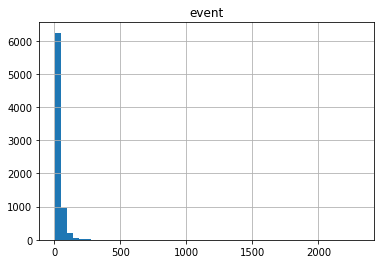

In [10]:
df_users.hist(bins = 50)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fcae1721f28>]],
      dtype=object)

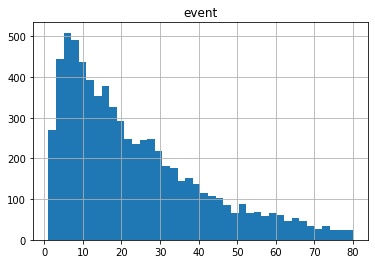

In [11]:
df_users[df_users['event'] <= 80].hist(bins = 40)

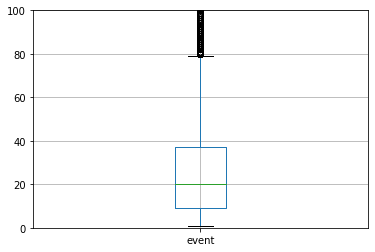

In [12]:
plt.ylim(0, 100)
df_users['event'].to_frame().boxplot()

Большое количество выбросов, присутствуют "маньяки", которые могут исказить данные, если окажутся в большинстве в одной из групп. Позже отсею таких пользователей из базы данных.

**Данными за какой период вы располагаете? Найдите максимальную и минимальную дату. Постройте гистограмму по дате и времени.**

In [13]:
df['date'].describe()

count         243713
unique            14
top       2019-08-01
freq           36141
Name: date, dtype: object

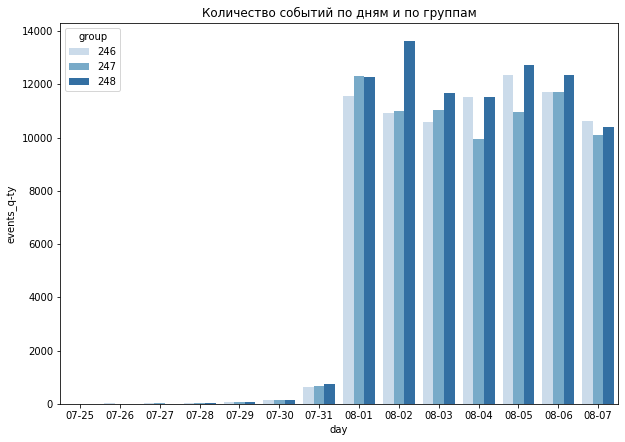

In [14]:
# подготовлю данные для графика. В задании просят гистограмму,
# но тут будет информативнее столбчатая диаграмма по каждому дню с разбивкой по группам
df_dates = df.groupby(['date','group']).agg({'event': 'count'}).reset_index()
df_dates['date'] = pd.to_datetime(df_dates['date'])
df_dates['day'] = df_dates['date'].map(lambda x: '0' + str(x.month) + '-' + ('0' if x.day < 10 else '') + str(x.day))
df_dates = df_dates.rename(columns = {'event':'events_q-ty'})

plt.figure(figsize=(10, 7))
plt.title('Количество событий по дням и по группам')
sns.barplot( x='day', y='events_q-ty', hue = 'group', data=df_dates, palette='Blues')

**Можно ли быть уверенным, что у вас одинаково полные данные за весь период? Технически в логи новых дней по некоторым пользователям могут «доезжать» события из прошлого — это может «перекашивать данные». Определите, с какого момента данные полные и отбросьте более старые. Данными за какой период времени вы располагаете на самом деле?**

Данные в июле в десятки раз ниже, чем в августе. Для дальнейшего анализа оставлю данные с первого августа.

In [15]:
df = df.drop(df[df['datetime'].dt.month == 7].index)

Определю пользователей с количеством событий более 80 (из оставшихся в датафрейме) и удалю их из базы данных.

In [16]:
df_users = df.groupby('user_id').agg({'event': 'count'})
df = df.drop(df[df['user_id'].isin(df_users[df_users['event'] > 80].index)].index)

**Много ли событий и пользователей вы потеряли, отбросив старые данные?**

In [17]:
total_events_1 = df['event'].count()
total_users_1 = df['user_id'].nunique()
print ('В датафрейме осталось {} событий из {} ({:.1%})'.format(total_events_1, total_events_0, \
                                                             total_events_1 / total_events_0))
print ('и {} пользователей из {} ({:.1%})'.format(total_users_1, total_users_0, \
                                         total_users_1 / total_users_0))

В датафрейме осталось 161607 событий из 243713 (66.3%)
и 7059 пользователей из 7551 (93.5%)


Отброшена небольшая часть пользователей, на которую приходилась треть всех событий. Продажи от этого не пострадают, а точность анализа только повысится.

**Проверьте, что у вас есть пользователи из всех трёх экспериментальных групп.**

In [18]:
df['group'].value_counts()

248    54962
246    53460
247    53185
Name: group, dtype: int64

## Шаг 4. Изучите воронку событий

**Посмотрите, какие события есть в логах, как часто они встречаются. Отсортируйте события по частоте.**

In [19]:
df['event'].value_counts()

MainScreenAppear           95092
OffersScreenAppear         29918
CartScreenAppear           20333
PaymentScreenSuccessful    15351
Tutorial                     913
Name: event, dtype: int64

**Посчитайте, сколько пользователей совершали каждое из этих событий. Отсортируйте события по числу пользователей. Посчитайте долю пользователей, которые хоть раз совершали событие.**

In [20]:
df_events = df.groupby('event').agg({'user_id': 'nunique'}).sort_values(by = 'user_id', ascending = False)
df_events = df_events.rename(columns = {'user_id':'unique_users'})
df_events ['total_conv_%'] = (df_events ['unique_users'] / df['user_id'].nunique() * 100).round(1)
df_events['next_step_conv_%'] = (df_events['unique_users'].pct_change() * 100 + 100).round(1)
df_events

,unique_users,total_conv_%,next_step_conv_%
event,,,
MainScreenAppear,6949,98.4,NaN
OffersScreenAppear,4138,58.6,59.5
CartScreenAppear,3293,46.6,79.6
PaymentScreenSuccessful,3106,44.0,94.3
Tutorial,762,10.8,24.5


**Предположите, в каком порядке происходят события. Все ли они выстраиваются в последовательную цепочку? Их не нужно учитывать при расчёте воронки.**

1) Выстраивается логичная последовательность [Главный экран -> Экран выбора продуктов -> Экран корзины -> Экран оплаты], из которой выпадает последний пункт - Руководство (*поэтому данные по конверсии в следующий шаг в табличке выше не имеют смысла*);

2) Из таблички выше видно, что не все пользователи из базы данных прошли воронку с самого начала -> следует проверить последовательность этапов воронки по каждому пользователю.

**По воронке событий посчитайте, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем). То есть для последовательности событий A → B → C, посчитайте отношение числа пользователей с событием B к количеству пользователей с событием A.**

In [21]:
#Последовательность этапов воронки по каждому пользователю:
df_users = df.pivot_table( index='user_id', columns='event', values='datetime', aggfunc='min')
df_users.sample(7)

event,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful,Tutorial
user_id,,,,,
4630185254631774491,2019-08-03 18:37:26,2019-08-03 18:37:24,2019-08-03 18:37:30,2019-08-03 18:37:26,NaT
1797441276328469589,NaT,2019-08-03 09:05:58,NaT,NaT,NaT
5339257593707075412,2019-08-03 17:34:21,2019-08-03 17:30:59,2019-08-03 17:33:51,2019-08-05 04:54:56,NaT
7179732420350905289,2019-08-02 17:15:29,2019-08-01 09:48:06,2019-08-01 09:48:13,2019-08-02 17:15:29,NaT
1097963955552992526,NaT,2019-08-03 07:57:57,NaT,NaT,NaT
6309333568791314319,NaT,2019-08-06 18:04:28,NaT,NaT,NaT
9070105870042240910,2019-08-01 21:24:42,2019-08-01 21:24:39,2019-08-01 21:25:05,2019-08-01 21:24:41,NaT


In [22]:
# условия для формирования воронки
# добавляю погрешность фиксации времени в 1 минуту
step_1 = ~df_users['MainScreenAppear'].isna()
step_2 = step_1 & (df_users['OffersScreenAppear'] > df_users['MainScreenAppear'] - pd.Timedelta(minutes=1))
step_3 = step_2 & (df_users['CartScreenAppear'] > df_users['OffersScreenAppear'] - pd.Timedelta(minutes=1))
step_4 = step_3 & (df_users['PaymentScreenSuccessful'] > df_users['CartScreenAppear'] - pd.Timedelta(minutes=1))

funnel_columns = ['event', 'unique_users']
funnel_data = [['MainScreenAppear', df_users[step_1].shape[0]],
               ['OffersScreenAppear', df_users[step_2].shape[0]],
               ['CartScreenAppear', df_users[step_3].shape[0]],
               ['PaymentScreenSuccessful', df_users[step_4].shape[0]]]
df_funnel = pd.DataFrame(data = funnel_data , columns = funnel_columns)
df_funnel ['total_conv_%'] = (df_funnel ['unique_users'] / df_users[step_1].shape[0] * 100).round(1)
df_funnel['next_step_conv_%'] = (df_funnel['unique_users'].pct_change() * 100 + 100).round(1)
df_funnel

,event,unique_users,total_conv_%,next_step_conv_%
0,MainScreenAppear,6949,100.0,NaN
1,OffersScreenAppear,3825,55.0,55.0
2,CartScreenAppear,2698,38.8,70.5
3,PaymentScreenSuccessful,2571,37.0,95.3


**На каком шаге теряете больше всего пользователей? Какая доля пользователей доходит от первого события до оплаты?**

Чуть больше половины пользователей доходит до второго шага воронки - просмотра предложения продукта. Именно на этом шаге отсеивается большинство потенциальных покупателей. На остальных шагах конверсия довольно высока.

37% пользователей проходят весь путь воронки - от главного экрана до успешной оплаты.

На основании анализа воронки марекетологам порекомендовал бы обратить внимание на интерфейс основного экрана, чтобы повысить ковнверсию в шаг просмотра товаров.

## Шаг 5. Изучите результаты эксперимента

**Сколько пользователей в каждой экспериментальной группе?**

Одно из условий успешного теста - "Попавший в одну из групп посетитель остаётся в этой группе до конца теста". Проверю, выполняется ли это условие в нашем случае.

In [23]:
group_matrix = pd.DataFrame(data = [], columns = [])
for i in range(246, 249):
    for k in range(246, 249):
        group_matrix.loc[i,k] = len(set(df[df['group'] == i]['user_id']) & set(df[df['group'] == k]['user_id']))
group_matrix

,246,247,248
246,2334.0,0.0,0.0
247,0.0,2355.0,0.0
248,0.0,0.0,2370.0


Отнесение пользователя к определённой группе работало исправно.

Теперь проверю, как соотносятся количества пользователей в группах.

In [24]:
# матрица относительных разниц количеств пользователей в группах в процентах
group_dif = df.groupby('group').agg({'user_id': 'nunique'})
group_dif.columns = ['users_qty']
for i in group_dif.index:
    for k in group_dif.index:
        group_dif.loc[i,k] = round(abs(group_dif.loc[i,'users_qty'] - group_dif.loc[k,'users_qty']) / \
                                    group_dif.loc[i,'users_qty'] * 100, 2)
group_dif

,users_qty,246,247,248
group,,,,
246,2334,0.00,0.90,1.54
247,2355,0.89,0.00,0.64
248,2370,1.52,0.63,0.00


Разница в численности групп 246 и 248 превышает 1%, что говорит о некорректности проведения A/B теста. Возможно, стоило бы продлить сбор данных для теста на несколько дней.

**Есть 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов. Проверьте, находят ли статистические критерии разницу между выборками 246 и 247.
Выберите самое популярное событие. Посчитайте число пользователей, совершивших это событие в каждой из контрольных групп. Посчитайте долю пользователей, совершивших это событие. Проверьте, будет ли отличие между группами статистически достоверным. Проделайте то же самое для всех других событий (удобно обернуть проверку в отдельную функцию). Можно ли сказать, что разбиение на группы работает корректно?**

In [25]:
# построю датафрейм с воронкой в разбивке по группам
# для этого сначала создам справочник user_id - group
df_user_group = df[['user_id', 'group']].drop_duplicates().reset_index(drop = True)
df_user_group.head(5)

,user_id,group
0,3737462046622621720,246
1,1433840883824088890,247
2,1182179323890311443,246
3,4613461174774205834,248
4,6121366368901703338,248


In [26]:
# теперь добавлю группу для каждого пользователя в ранее созданный датафрейм
df_users = df_users.merge(df_user_group, on = 'user_id')
# аналогично тому, как делал в анализе воронки, но теперь с разбивкой на группы
step_1 = ~df_users['MainScreenAppear'].isna()
step_2 = step_1 & (df_users['OffersScreenAppear'] > df_users['MainScreenAppear'] - pd.Timedelta(minutes=1))
step_3 = step_2 & (df_users['CartScreenAppear'] > df_users['OffersScreenAppear'] - pd.Timedelta(minutes=1))
step_4 = step_3 & (df_users['PaymentScreenSuccessful'] > df_users['CartScreenAppear'] - pd.Timedelta(minutes=1))

df_funnel_group = pd.DataFrame({'event': ['MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful']})
for i in range(246, 249):
     df_funnel_group[i] = [df_users[step_1 & (df_users['group'] == i)].shape[0],
                           df_users[step_2 & (df_users['group'] == i)].shape[0],
                           df_users[step_3 & (df_users['group'] == i)].shape[0],
                           df_users[step_4 & (df_users['group'] == i)].shape[0]]
df_funnel_group

,event,246,247,248
0,MainScreenAppear,2301,2321,2327
1,OffersScreenAppear,1294,1254,1277
2,CartScreenAppear,916,895,887
3,PaymentScreenSuccessful,871,845,855


In [27]:
# напишу функцию для расчёта p-значения
# на входе: шаг, для которого смотрим конверсию
# и два списка групп, для которых проверяем гипотезу о равенстве конверсий
def p_val (step, groups1, groups2):
    # строю массивы successes и trials в зав-ти от входных данных
    successes = np.array([0, 0])
    trials = np.array([0, 0])
    for group in groups1:
        successes[0] = successes[0] + df_funnel_group.loc[step, group]
        trials[0] = trials[0] + df_funnel_group.loc[step-1, group]
    for group in groups2:
        successes[1] = successes[1] + df_funnel_group.loc[step, group]
        trials[1] = trials[1] + df_funnel_group.loc[step-1, group]
    # применяю формулы
    p1 = successes[0]/trials[0]
    p2 = successes[1]/trials[1]
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])
    difference = p1 - p2
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))
    distr = st.norm(0, 1) 
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    return p_value

# применю эту функцию в цикле: шаги от 1 до 3 для групп 246 и 247 (A/A-тест)
# критический уровень статистической значимости выберу равным .01

for i in range(1,4):
    df_funnel_group.loc[i,'A/A_p_value'] = round(p_val(i, [246], [247]), 3)
df_funnel_group

,event,246,247,248,A/A_p_value
0,MainScreenAppear,2301,2321,2327,NaN
1,OffersScreenAppear,1294,1254,1277,0.131
2,CartScreenAppear,916,895,887,0.745
3,PaymentScreenSuccessful,871,845,855,0.520


Нет оснований отвергнуть нулевую гипотезу, конверсии на каждом шаге воронки для групп 246 и 247 могут быть равными (в пределах выбранного уровня стат. значимости).

**Аналогично поступите с группой с изменённым шрифтом. Сравните результаты с каждой из контрольных групп в отдельности по каждому событию. Сравните результаты с объединённой контрольной группой. Какие выводы из эксперимента можно сделать?**

In [28]:
for i in range(1,4):
    df_funnel_group.loc[i,'A1/B_p_value'] = round(p_val(i, [246], [248]), 3)
    df_funnel_group.loc[i,'A2/B_p_value'] = round(p_val(i, [247], [248]), 3)
    df_funnel_group.loc[i,'A/B_p_value'] = round(p_val(i, [246, 247], [248]), 3)
    df_funnel_group.loc[i,'A_total_conv_%'] = round((df_funnel_group.loc[i,246] + df_funnel_group.loc[i,247]) / \
                                              (df_funnel_group.loc[0,246] + df_funnel_group.loc[0,247]) * 100, 1)
    df_funnel_group.loc[i,'B_total_conv_%'] = round(df_funnel_group.loc[i,248] / df_funnel_group.loc[0,248] * 100, 1)
df_funnel_group

,event,246,247,248,A/A_p_value,A1/B_p_value,A2/B_p_value,A/B_p_value,A_total_conv_%,B_total_conv_%
0,MainScreenAppear,2301,2321,2327,NaN,NaN,NaN,NaN,NaN,NaN
1,OffersScreenAppear,1294,1254,1277,0.131,0.352,0.561,0.843,55.1,54.9
2,CartScreenAppear,916,895,887,0.745,0.462,0.292,0.301,39.2,38.1
3,PaymentScreenSuccessful,871,845,855,0.520,0.171,0.046,0.059,37.1,36.7


Не получилось отвергнуть нулевую гипотезу, нет оснований считать конверсии в группе B и группах A разными.

**Какой уровень значимости вы выбрали при проверке статистических гипотез выше? Посчитайте, сколько проверок статистических гипотез вы сделали. При уровне значимости 0.1 каждый десятый раз можно получать ложный результат. Какой уровень значимости стоит применить? Если вы хотите изменить его, проделайте предыдущие пункты и проверьте свои выводы.**

Проверено 12 стат. гипотез, лишь в одной из них p_value приблизился к 5% (в остальных случаях он гораздо выше) - на шаге от корзины до оплаты (конверсия группы B при этом выше). Но итоговая конверсия группы B по этой выборке даже ниже итоговой конверсии по группам A.

## Итоги и выводы

* Исходные данные за июль и за август сильно разнятся по количеству событий -> нужно уточнить, как поступают данные, нет ли системной ошибки.
* Большая часть пользователь не доходит от главного экрана до просмотра продуктов и предложений -> марекетологам порекомендую обратить внимание на интерфейс основного экрана, чтобы повысить ковнверсию в шаг просмотра товаров.
* Разница в численности групп 246 и 248 превышает 1%, что говорит о некорректности проведения A/B теста -> предлагаю продлить сбор данных для теста на несколько дней.
* По имеющимся данным влияние шрифта на поведение пользователей не подтвердилось -> внесение изменений не оправдано (но есть вероятность, что продление теста приведёт к другому выводу). 